# DL Lab 4.1 - Homework - Generating Flower Images with Deep Convolutional GANs

In this DL lab you will implement a [Generative Adversarial Network](https://arxiv.org/abs/1406.2661). Remember the first part of Assignment 2? You implemented a model that learned to generate adversarial noise in order to trick a classifier. The classifier on the other hand was given no chance to learn how to deal with that adversarial noise.

In GANs, however, two models are trained **simultaneously** by an adversarial process. The idea is having a **generator** learning to create images that look real, while a **discriminator** learns to distinguish real images from generated ones (fakes). Both become progressively better until the **generator** creates realistic-looking images so that the **discriminator** cannot tell the difference anymore.

You will implement a DC GAN following the architecture guidelines for **stable Deep Convolutional GANs** proposed in [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434) by Radford et al., along with some best practices for DC GANs as summarized in a great [blogpost by Jason Brownlee](https://machinelearningmastery.com/how-to-code-generative-adversarial-network-hacks/) and using the resize convolution technique proposed by [Odena et al.](https://distill.pub/2016/deconv-checkerboard/).

*Disclaimer*: This notebook is partly based on the TensorFlow Tutorial [Deep Convolutional Generative Adversarial Network](https://www.tensorflow.org/tutorials/generative/dcgan).

# 0 - Setup

In [1]:
#@title Download and import `utils`

import requests, os, zipfile
import numpy as np

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

# download utils
download_file_from_google_drive('1WYTduftimsNEPmy9yTRU5YEIRywZezW1', '/content/utils.py')

import utils

In [2]:
#@title Print TF version and GPU stats
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import sys
print('TensorFlow version:', tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name), '', sep='\n')
!nvidia-smi

TensorFlow version: 2.4.1
Found GPU at: /device:GPU:0

Thu Jan 28 11:22:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    35W /  70W |    227MiB / 15079MiB |      8%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                 

In [3]:
import glob, imageio, os, PIL
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from IPython import display

# 1 - Load and Prepare Data

In [4]:
#@title Download flower image dataset
# Download dataset
download_file_from_google_drive('1BoDcLIEqfb9qD5VJBKr4BhArluPyOBrh', '/tmp/binary_flowers.npz')
with np.load('/tmp/binary_flowers.npz') as data:
    X_train, y_train, X_test, y_test = [ data[key] for key in ['X_train', 'y_train', 'X_test', 'y_test'] ]

# Merge train and test data
X_train = np.concatenate( (X_train, X_test), axis=0)
y_train = np.concatenate( (y_train, y_test), axis=0)

# Remove non-flower images
X_train = X_train[y_train==1,:]

# Scale to [-1,+1]:
X_train *= 2.

In [5]:
print(X_train.shape)

(1000, 64, 64, 3)


Remember our first dataset? We used 1000 images of shape $64 \times 64 \times 3$ displaying 10 different flower classes. That is not so much. In order to add some more variance to the dataset, let us use some random horizontal flips for data augmentation:

In [6]:
def flip(x):
  x = tf.image.random_flip_left_right(x)
  return x

Next, we can create a `tf.data.Dataset` for training on mini-batches of size 64:

In [7]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).map(flip).batch(BATCH_SIZE)

# 2 - Create Models

Next, we create the models, i.e., one Generator and one Discriminator, using Keras' Functional API.
We follow the best practice for DCGAN weight initialization using a zero-centered Gaussian with a standard deviation of `0.02`.

In [8]:
weight_init = tf.keras.initializers.RandomNormal(mean=0.0,
                                                 stddev=0.02)

## 2.1 - The Generator

### Option A) Upsampling by Transposed Convolutions

The original DC GAN generator uses [fractionally strided (aka transposed) convolution](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) layers to produce an image from random noise (aka "the seed"). We start with a dense layer fed with this seed, and then upsample several times until reaching the desired image shape of $64 \times 64 \times 3$. Our real images are min-max scaled to [-1, +1], hence we use `tanh` activation for the output layer. The remaining layers use [LeakyReLU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU) activation for avoiding dead neurons.

In [9]:
def build_generator_model(noise_dim):
  '''Using transposed convolutions for upsampling.'''
  
  gen_input = layers.Input( shape=(noise_dim,) )
  
  x = layers.Dense(8*8*512, use_bias=False)(gen_input)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)
  x = layers.Reshape( (8, 8, 512) )(x)

  # First upsampling
  x = layers.Conv2DTranspose(filters=256,
                             kernel_size=5,
                             strides=2,
                             padding='same',
                             kernel_initializer=weight_init,
                             use_bias=False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  # Second upsampling 
  x = layers.Conv2DTranspose(filters=128,
                             kernel_size=5,
                             strides=2,
                             padding='same',
                             kernel_initializer=weight_init,
                             use_bias=False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  # Third upsampling 
  x = layers.Conv2DTranspose(filters=64,
                             kernel_size=5,
                             strides=2,
                             padding='same',
                             kernel_initializer=weight_init,
                             use_bias=False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  ### START YOUR CODE HERE ###  (1 LOC)
  gen_output = layers.Dense(3, use_bias=False, kernel_initializer=weight_init, activation='tanh')(x)

  # Create output

  ### END YOUR CODE HERE ###

  return Model(gen_input, gen_output, name='transposed_convolution')

### Option B) Upsampling by Resize-Convolutions

Fractionally strided convolutions, aka transposed convolutions, often effect checkerboard-like artifact patterns, especially in images with strong colors. The root cause of these artifacts is the uneven overlap when the convolution kernel size is not divisble by the stride, e.g., as with `s=2` and `f=5`. The network might learn to avoid this, however, in practice it is easier to simply avoid this.

Instead of transposed convolutions, we will use an alternative upsampling method proposed by [Odena et al.](https://distill.pub/2016/deconv-checkerboard/), i.e., the **resize-convolution** approach, in which upsampling to a higher resolution is separated from convolution. The resize-convolution can be easily implemented in Keras using the [`UpSampling2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D) layer with nearest-neighbor interpolation, eventually followed by a [`Convolution2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layer with `same` zero-padding.

In [10]:
def build_generator_model(noise_dim):
  '''Using resize-convolutions for upsampling.'''
  
  gen_input = layers.Input( shape=(noise_dim,) )
  
  x = layers.Dense(8*8*512, use_bias=False)(gen_input)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)
  x = layers.Reshape( (8, 8, 512) )(x)

  # First upsampling
  x = layers.UpSampling2D(2)(x)
  x = layers.Conv2D(filters=256,
                    kernel_size=5,
                    padding='same',
                    kernel_initializer=weight_init,
                    use_bias=False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  # Second upsampling 
  x = layers.UpSampling2D(2)(x)
  x = layers.Conv2D(filters=128,
                    kernel_size=5,
                    padding='same',
                    kernel_initializer=weight_init,
                    use_bias=False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  # Third upsampling 
  x = layers.UpSampling2D(2)(x)
  x = layers.Conv2D(filters=64,
                    kernel_size=5,
                    padding='same',
                    kernel_initializer=weight_init,
                    use_bias=False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  ### START YOUR CODE HERE ###  (1 LOC)
  gen_output = layers.Dense(3, use_bias=False, activation='tanh')(x)
  # Create output

  ### END YOUR CODE HERE ###

  return Model(gen_input, gen_output, name='resize_convolution')

Test the (untrained) generator:

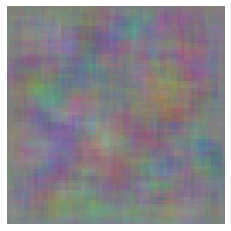

In [11]:
# Set dimension of generator input vector
noise_dim = 100

# Initialize an instance of the generator model
generator = build_generator_model(noise_dim)

# Create some noise
noise = tf.random.normal([1, noise_dim])

# Generator an image out of that noise
generated_image = generator(noise, training=False)

# Plot image
plt.imshow((generated_image[0,:]+1.)/2.)
plt.axis('off')
plt.show()

In [12]:
print(generator.summary())

Model: "resize_convolution"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 32768)             3276800   
_________________________________________________________________
batch_normalization (BatchNo (None, 32768)             131072    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 512)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 256)

## 2.2 - The Discriminator

The discriminator is a dead-simple ConvNet for binary image classification. Note again the usage of BatchNormalization and LeakyReLU activation.

In [13]:
def build_discriminator_model():

  disc_input = layers.Input( shape=(64, 64, 3) )

  # First convolution
  x = layers.Conv2D(filters=64,
                    kernel_size=3,
                    strides=2,
                    kernel_initializer=weight_init,
                    padding='same',
                    use_bias='False')(disc_input)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  # Second convolution
  x = layers.Conv2D(filters=128,
                    kernel_size=3,
                    strides=2,
                    kernel_initializer=weight_init,
                    padding='same',
                    use_bias='False')(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  # Third convolution
  x = layers.Conv2D(filters=256,
                    kernel_size=3,
                    strides=2,
                    kernel_initializer=weight_init,
                    padding='same',
                    use_bias='False')(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  ### START YOUR CODE HERE ###  (2 LOC)
  
  # Classifier
  x = layers.Flatten()(x)
  disc_output = layers.Dense(1, activation='sigmoid')(x)

  ### END YOUR CODE HERE ###
    
  return Model(disc_input, disc_output, name='discriminator')


Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [14]:
# Initialize an instance of the discriminator model
discriminator = build_discriminator_model()

# Test the discriminator on the generated image
decision = discriminator.predict(generated_image)[0]
print('Probability of being real: {:.2f}%'.format(decision[0]*100))

Probability of being real: 50.01%


# 3 - Loss and Optimizers

## 3.1 - Label Smoothing

It is common to use the class label 1 for real images and class label 0 for fake images. Instead of these "hard" labels, it is a good practice to use "soft" labels, i.e., values slightly larger or smaller than 1 for real images, or slightly more than 0 for fake images. The variation for each image is random.
This is referred to as [label smoothing](https://arxiv.org/abs/1606.03498) and can have a regularizing effect when training the model.

There have been some suggestions that only "one-sided" label smoothing, i.e., smoothing only the positive class label, is required. However, you can also smooth the negative class labels.

**Task**: Complete the functions below for smoothing input labels `y` into  uniformly into the range `[0.7, 1.2]` for positive labels, and into the range `[0.0, 0.3]` for negative labels.

In [15]:
def smooth_positive_labels(y):
    return y - 0.3 + (np.random.random(y.shape) * 0.5)

def smooth_negative_labels(y):
	return y + np.random.random(y.shape) * 0.3

## 3.2 - Discriminator Loss
This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [16]:
def discriminator_loss(real_output, fake_output):
  
  # Ground thruth labels
  real_output_gt = tf.ones_like(real_output)
  fake_output_gt = tf.zeros_like(fake_output)

  ### START YOUR CODE HERE ###  (4 LOC)

  # Label smoothing on real samples
  real_output_gt = tf.ones_like(real_output)
  real_loss = tf.keras.losses.BinaryCrossentropy()(real_output_gt, real_output)
  # Label smoothing on fake samples
  fake_output_gt = tf.zeros_like(fake_output)
  fake_loss = tf.keras.losses.BinaryCrossentropy()(fake_output_gt, fake_output)

  # Compute loss

  ### END YOUR CODE HERE ###
  
  return real_loss + fake_loss

##3.3 - Generator Loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [17]:
def generator_loss(fake_output):

  # Ground truth labels
  fake_output_gt = tf.ones_like(fake_output)

  ### START YOUR CODE HERE ###  (1 LOC)
  fake_output_gt = tf.ones_like(fake_output)
  # Label smoothing on fake samples

  ### END YOUR CODE HERE ###
  
  return tf.keras.losses.BinaryCrossentropy()(fake_output_gt, fake_output)

##3.4 - Separate Optimizers
The discriminator and the generator optimizers are different since we will train two networks separately.

In [18]:
generator = build_generator_model(noise_dim)
generator_optimizer = tf.keras.optimizers.Adam(lr=1e-4,
                                               beta_1=.5)

discriminator = build_discriminator_model()
discriminator_optimizer = tf.keras.optimizers.Adam(lr=1e-4,
                                                   beta_1=.5)

##3.5 - Checkpointing
As GAN training can take a lot of time, you might want to store checkpoints.
In addition, we've already trained the two GAN models for 1000 epochs, so you might want to load and continue from the checkpoints provided by us.

In [19]:
# Select the checkpoint path for the correct model architecture
if any('Conv2DTranspose' in str(layer.__class__) for layer in generator.layers):
  # Checkpoint path for generator based on transposed convolution
  CKPT_PATH = './ckp_train_dcgan_transposedconv'
elif any('UpSampling2D' in str(layer.__class__) for layer in generator.layers):
  # Checkpoint path for generator based on resize-convolution
  CKPT_PATH = './ckp_train_dcgan_resizeconv'

In [20]:
#@title Download Checkpoint
if any('Conv2DTranspose' in str(layer.__class__) for layer in generator.layers):
  print('Downloading checkpoint for transposed convolution model.')
  download_file_from_google_drive('1Er7SMq6nU1Ig5nLZhX9aOxxJl-MuJYNC', 'ckp.zip')
if any('UpSampling2D' in str(layer.__class__) for layer in generator.layers):
  print('Downloading checkpoint for resize-convolution model.')
  download_file_from_google_drive('1cwXmZQjBEG13WsVdCVlrOcTb1qj9T4VI', 'ckp.zip')
utils.unzip('ckp.zip', CKPT_PATH)
!rm -rf ckp.zip

unzipping to  ./ckp_train_dcgan_resizeconv


In [21]:
# uncomment next line to train from scratch
#!rm -rf $CKPT_PATH

In [22]:
CKPT = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                           discriminator_optimizer=discriminator_optimizer,
                           generator=generator,
                           discriminator=discriminator)
CKPT_MANAGER = tf.train.CheckpointManager(CKPT,
                                          CKPT_PATH,
                                          max_to_keep=5)
# Save every CKPT_EPOCHS epochs
CKPT_EPOCHS = 50

START_EPOCH = 0
if CKPT_MANAGER.latest_checkpoint:
  START_EPOCH = int(CKPT_MANAGER.latest_checkpoint.split('-')[-1]) * CKPT_EPOCHS
  print('Checkpoint found. Continuing from epoch {}'.format(START_EPOCH))
  CKPT.restore(CKPT_MANAGER.latest_checkpoint)

# Remove saved gallery of fakes, if present
!rm image_at_epoch_*.png

Checkpoint found. Continuing from epoch 1000


# 4 - Training

## 4.1 - Define the Training Loop

We define a `train_step` that will be called iteratively in the `train` function. Per step, the generator receives `BATCH_SIZE` number of random seed vectors as input and generates `BATCH_SIZE` fake images. The discriminator is then used to classify real images (drawn from the training set) and the generated fakes images. The loss is calculated for each model, and the gradients are used to update the generator and discriminator respectively.

In [23]:
# `tf.function` decorator for "compiling" the function
@tf.function
def train_step(images):

  # Create noise
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

    # Create fake images
    generated_images = generator(noise, training=True)

    # Predict on real images
    real_output = discriminator(images, training=True)

    # Predict on fake images
    fake_output = discriminator(generated_images, training=True)

    # Compute loss
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  # Compute gradients by automatic differentiation
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  # Update weights by applying the gradients
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return gen_loss, disc_loss

In [24]:
def train(dataset, epochs, plt_epochs=10):

  history = {'generator_loss':list(),
             'discriminator_loss':list()}

  for epoch in range(START_EPOCH, epochs):

    gen_loss = list()
    disc_loss = list()

    for image_batch in dataset:

      # Process batch
      gen_loss_step, disc_loss_step = train_step(image_batch)

      # Store the losses
      gen_loss.append(gen_loss_step)
      disc_loss.append(disc_loss_step)
      
    # Compute mean losses across epoch
    history['generator_loss'].append( np.mean(gen_loss) )
    history['discriminator_loss'].append( np.mean(disc_loss) )

    # Produce images for the GIF
    if (epoch + 1) % plt_epochs == 0:
      display.clear_output(wait=True)
      generate_and_save_images(generator, epoch + 1, seed)
    
    print('Epoch: {}, Loss (G): {}, Loss (D): {}'.format(epoch, np.mean(gen_loss), np.mean(disc_loss)))

    # Save the model every `CKPT_EPOCHS` epochs
    if (epoch + 1) % CKPT_EPOCHS == 0:
      CKPT_MANAGER.save()
  
  # Generate images after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  
  return history

In [25]:
#@title Helper functions: `generate_and_save_images` and `plot_losses`

def generate_and_save_images(model, epoch, test_input, save=True, figsize=(4,4)):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm)
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=figsize)

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow((predictions[i, :]+1)/2.)
      plt.axis('off')
  
  if save:
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

def plot_losses(history):
  plt.figure(figsize=(10,5))
  
  plt.plot(history['generator_loss'], 
           label='Generator')
  plt.plot(history['discriminator_loss'], 
           label='Discriminator')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  ymax = plt.ylim()[1]
  plt.show()

## 4.2 - Train!
Call the `train` method defined above to train the generator and discriminator simultaneously. Note, GANs are difficult to train. It's important that the generator and discriminator do not overpower each other. However, there is no good theoretical foundation as to how to truly assess the learning process as well as the reults.

At the beginning of the training, the generated images look like random noise. As training progresses, the images will look increasingly real. After about 300 epochs, they start to resemble (cauli)flowers...

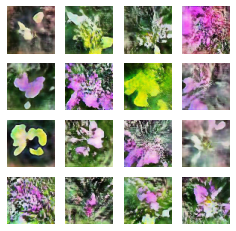

In [26]:
num_examples_to_generate = 16

# We will reuse this seed overtime to visualize progress in an animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Train
epochs = 1100
history = train(train_dataset, epochs, plt_epochs=5)

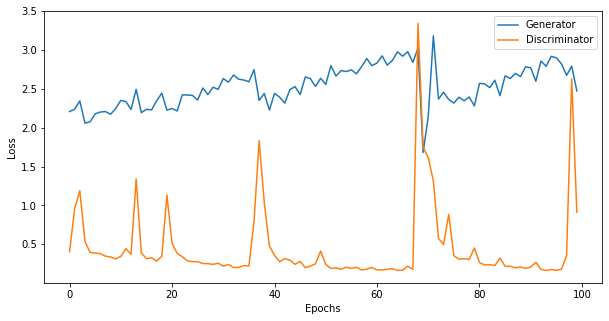

In [27]:
plot_losses(history)

Let's plot some examples:

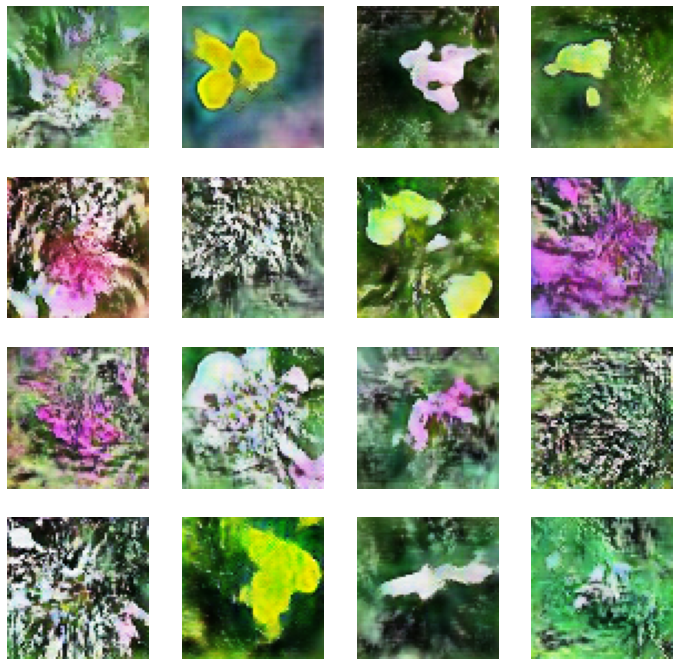

In [28]:
generate_and_save_images(generator, 
                         epochs, 
                         tf.random.normal([num_examples_to_generate, noise_dim]), 
                         save=False,
                         figsize=(12,12))

# 5 - Create a GIF
Use imageio to create an animated gif using the images saved during training:

In [29]:
# To generate GIFs
!pip install -q imageio

# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

anim_file = '{}_ep{}.gif'.format(CKPT_PATH.split('_')[-1], epochs)

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

Download the GIF to your local drive:

In [30]:
from google.colab import files
files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
# Zip the CKPT
ckp_zip = CKPT_PATH + '.zip'

print('Zipping "{}"'.format(CKPT_PATH))
!zip -r $ckp_zip $CKPT_PATH

Zipping "./ckp_train_dcgan_resizeconv"
  adding: ckp_train_dcgan_resizeconv/ (stored 0%)
  adding: ckp_train_dcgan_resizeconv/ckpt-20.data-00000-of-00002 (deflated 87%)
  adding: ckp_train_dcgan_resizeconv/ckpt-21.data-00000-of-00001 (deflated 9%)
  adding: ckp_train_dcgan_resizeconv/ckpt-21.index (deflated 74%)
  adding: ckp_train_dcgan_resizeconv/.ipynb_checkpoints/ (stored 0%)
  adding: ckp_train_dcgan_resizeconv/checkpoint (deflated 71%)
  adding: ckp_train_dcgan_resizeconv/ckpt-20.data-00001-of-00002 (deflated 9%)
  adding: ckp_train_dcgan_resizeconv/ckpt-22.index (deflated 74%)
  adding: ckp_train_dcgan_resizeconv/ckpt-20.index (deflated 75%)
  adding: ckp_train_dcgan_resizeconv/ckp_train_dcgan_resizeconv/ (stored 0%)
  adding: ckp_train_dcgan_resizeconv/ckp_train_dcgan_resizeconv/ckpt-20.data-00000-of-00002 (deflated 87%)
  adding: ckp_train_dcgan_resizeconv/ckp_train_dcgan_resizeconv/.ipynb_checkpoints/ (stored 0%)
  adding: ckp_train_dcgan_resizeconv/ckp_train_dcgan_resizeconv

***

# Congratulations!

You may now submit your notebook to moodle:
- Save the notebook (`CTRL`+ `s` or '*File*' -> '*Save*')
- Click on '*File*' -> '*Download .ipynb*' for downloading the notebook as IPython Notebook file.
- Upload the downloaded IPython Notebook file to **Moodle**.